2025-05-05 18:53:15.913628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746471196.229316      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746471196.305965      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
directory_path = "/kaggle/input/potatoes-data/PlantVillage"

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


I0000 00:00:1746471222.069679      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746471222.070431      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


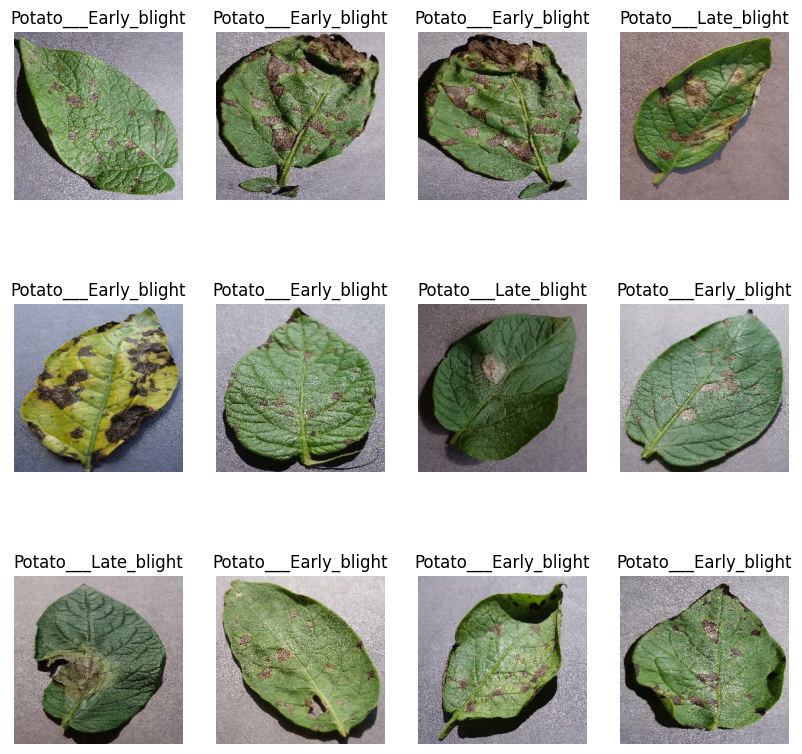

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [12]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [36]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [37]:
from tensorflow.keras import layers
from tensorflow import keras

resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [38]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [39]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
from tensorflow.keras import layers, models

# Correct input shape (without batch size)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
layers.Input(shape=input_shape)

model = models.Sequential([
    layers.Input(batch_shape=(32, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # fixed batch size
# <--- define input shape here
    resize_and_rescale,                        # this should be a valid preprocessing layer
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [41]:
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)           │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [43]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15


I0000 00:00:1746472360.490992     101 service.cc:148] XLA service 0x7b847800a9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746472360.494291     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746472360.494318     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746472360.965737     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/54 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.1172 - loss: 1.1187  

I0000 00:00:1746472367.171021     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 375ms/step - accuracy: 0.4297 - loss: 0.9614 - val_accuracy: 0.6562 - val_loss: 0.8657
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.5750 - loss: 0.8144 - val_accuracy: 0.6719 - val_loss: 0.6697
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step - accuracy: 0.7327 - loss: 0.6175 - val_accuracy: 0.7240 - val_loss: 0.5424
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - accuracy: 0.7943 - loss: 0.4611 - val_accuracy: 0.8542 - val_loss: 0.4477
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 297ms/step - accuracy: 0.8719 - loss: 0.3338 - val_accuracy: 0.8281 - val_loss: 0.4132
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step - accuracy: 0.8720 - loss: 0.3080 - val_accuracy: 0.7812 - val_loss: 0.6585
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step - accuracy: 0.9032 - loss: 0.2603 - val_accuracy: 0.9375 - val_loss: 0.1786
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - accuracy: 0.9429 - loss: 0.1589 - val_accuracy: 0.927

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import HTML


In [45]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

# Define the image transformations (resize and normalization)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder(root=directory_path, transform=transform)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [47]:
class_names = dataset.classes
print(class_names)

# Get one batch to check the data
for image_batch, labels_batch in data_loader:
    print(image_batch.shape)
    print(labels_batch)
    break


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
torch.Size([32, 3, 256, 256])
tensor([1, 1, 0, 0, 1, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0])


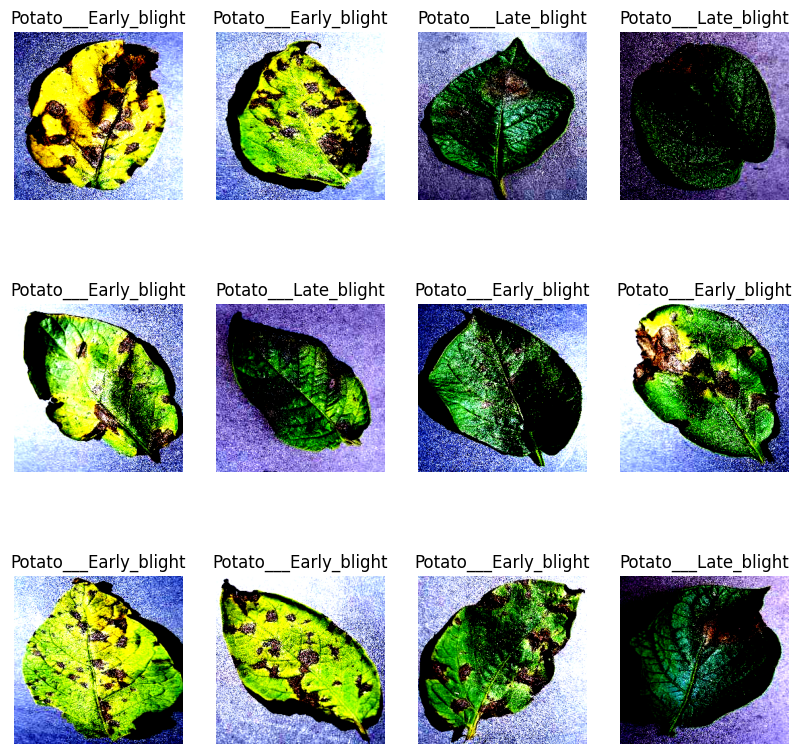

In [48]:
import matplotlib.pyplot as plt

# Visualize one batch of images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data_loader:
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].permute(1, 2, 0).numpy())  # Convert to HWC format
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
    break  # Only need one batch


In [49]:
from torch.utils.data import random_split

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader for each dataset
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


In [54]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define image transformations (MUST include ToTensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts PIL image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Optional but recommended
])

# Load dataset with transform
dataset = datasets.ImageFolder(root=directory_path, transform=transform)

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [55]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * IMAGE_SIZE//32 * IMAGE_SIZE//32, 64),  # Adjust based on final image size after pooling
            nn.ReLU(),
            nn.Linear(64, n_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = CNNModel()


68


In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
for epoch in range(10):
    
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0
    inner_loop_counter = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        inner_loop_counter+=1
        print(f"{inner_loop_counter}/68")
    print(f"iteration {epoch+1 } completed" )
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total}")


1/68
2/68
3/68
4/68
5/68
6/68
7/68
8/68
9/68
10/68
11/68
12/68
13/68
14/68
15/68
16/68
17/68
18/68
19/68
20/68
21/68
22/68
23/68
24/68
25/68
26/68
27/68
28/68
29/68
30/68
31/68
32/68
33/68
34/68
35/68
36/68
37/68
38/68
39/68
40/68
41/68
42/68
43/68
44/68
45/68
46/68
47/68
48/68
49/68
50/68
51/68
52/68
53/68
54/68
55/68
56/68
57/68
58/68
59/68
60/68
61/68
62/68
63/68
64/68
65/68
66/68
67/68
68/68
iteration 1 completed
Epoch [1/15], Loss: 0.2347356788266231, Accuracy: 91.682156133829
1/68
2/68
3/68
4/68
5/68
6/68
7/68
8/68
9/68
10/68
11/68
12/68
13/68
14/68
15/68
16/68
17/68
18/68
19/68
20/68
21/68
22/68
23/68
24/68
25/68
26/68
27/68
28/68
29/68
30/68
31/68
32/68
33/68
34/68
35/68
36/68
37/68
38/68
39/68
40/68
41/68
42/68
43/68
44/68
45/68
46/68
47/68
48/68
49/68
50/68
51/68
52/68
53/68
54/68
55/68
56/68
57/68
58/68
59/68
60/68
61/68
62/68
63/68
64/68
65/68
66/68
67/68
68/68
iteration 2 completed
Epoch [2/15], Loss: 0.14798073991037466, Accuracy: 94.47026022304833
1/68
2/68
3/68
4/68
5/6

In [65]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():  # No gradients during inference
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy}%")


Test Loss: 0.0029, Test Accuracy: 97.0068%


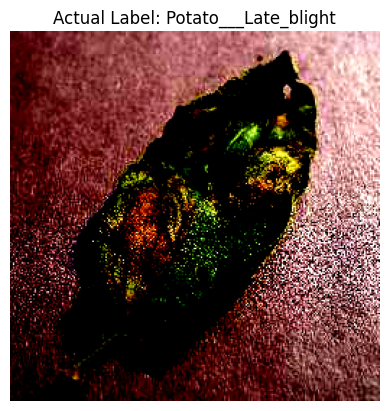

Predicted Label: Potato___Late_blight


In [67]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get one batch from the test DataLoader
dataiter = iter(test_loader)
images_batch, labels_batch = next(dataiter)

# Select the first image and label
first_image = images_batch[0]
first_label = labels_batch[0]

# Show the image
plt.imshow(np.transpose(first_image.numpy(), (1, 2, 0)))  # CxHxW -> HxWxC
plt.title(f"Actual Label: {class_names[first_label]}")
plt.axis("off")
plt.show()

# Model prediction
model.eval()
with torch.no_grad():
    outputs = model(first_image.unsqueeze(0))  # Add batch dimension
    _, predicted = torch.max(outputs, 1)
    predicted_label = predicted.item()

print("Predicted Label:", class_names[predicted_label])


In [68]:
import torch
from torchvision import transforms
import numpy as np

# Define the same transforms used during training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

def predict(model, img, class_names):
    model.eval()
    
    # If the image is a PIL Image, transform it
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probs, 1)
    
    predicted_label = class_names[predicted_class.item()]
    confidence_score = round(confidence.item() * 100, 2)

    return predicted_label, confidence_score


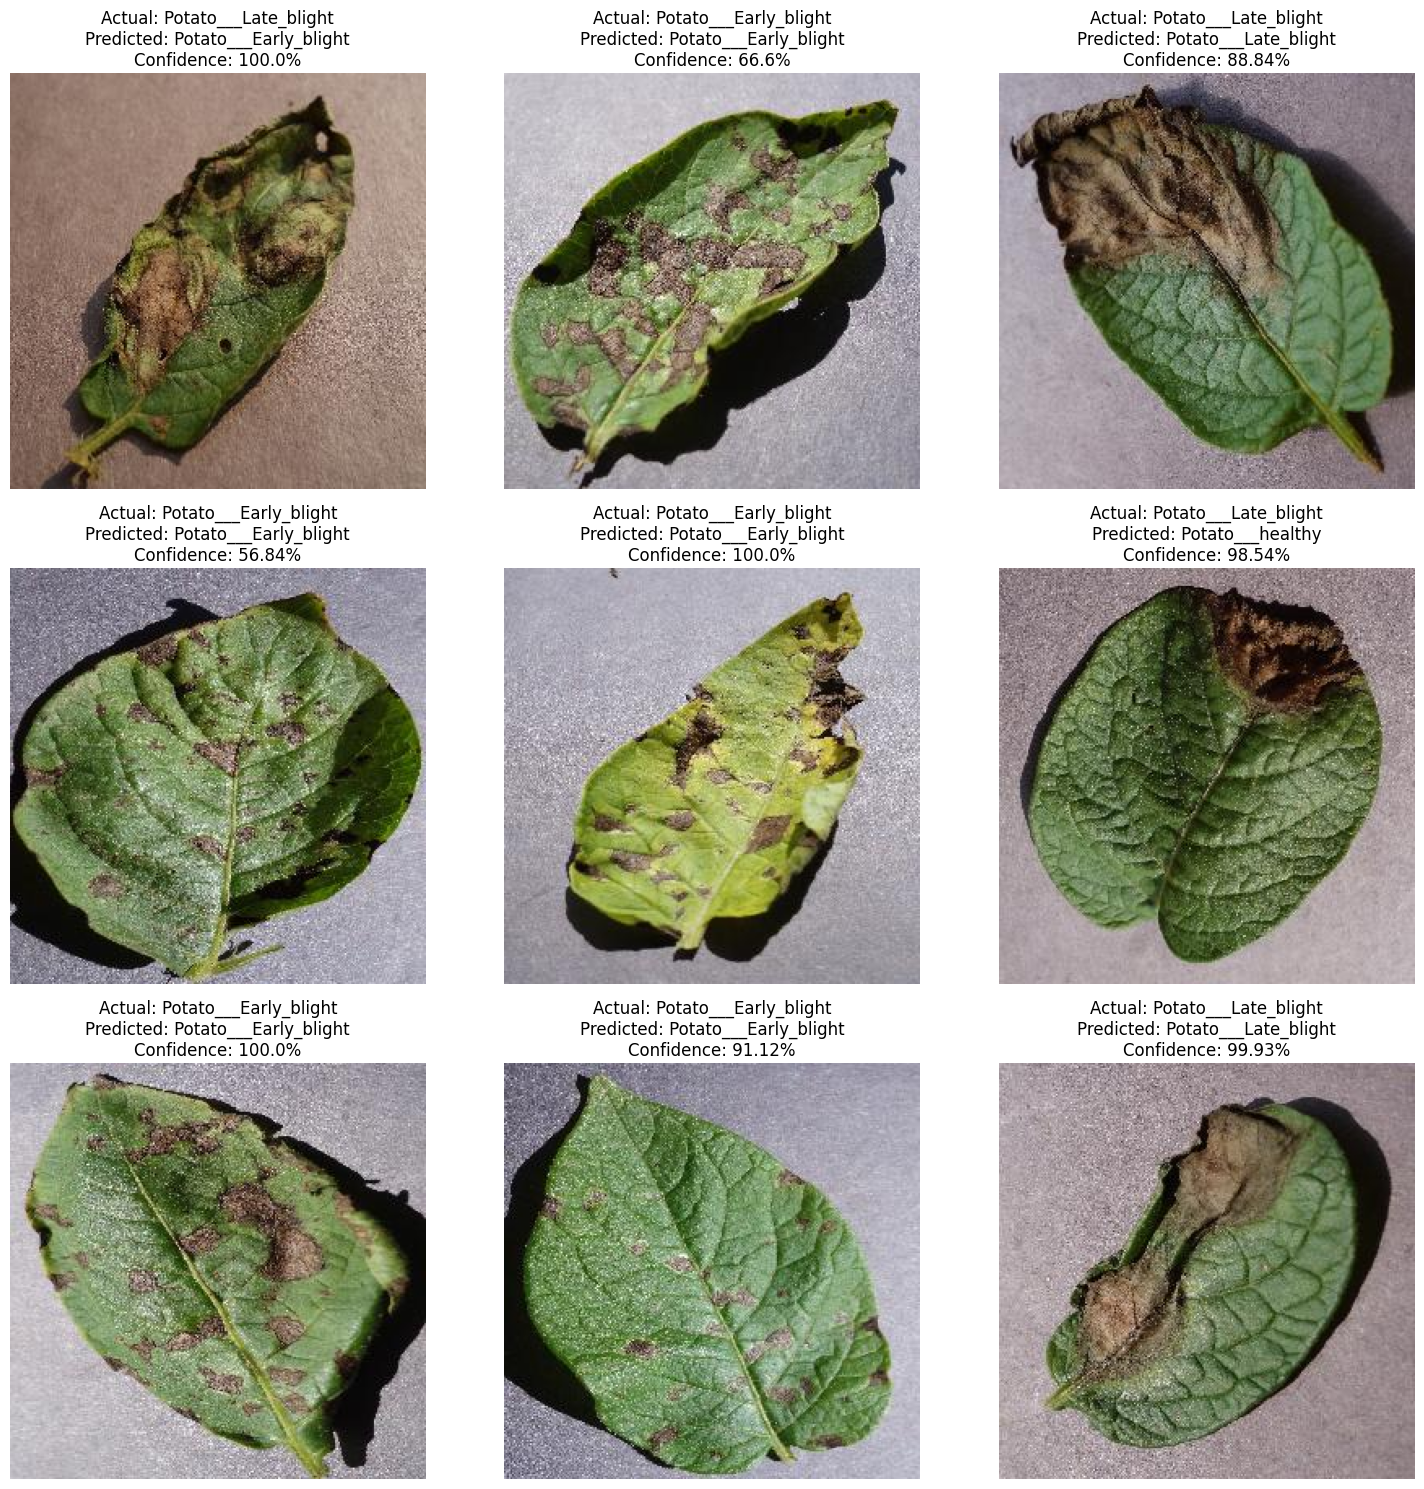

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
from PIL import Image

# Optional: reverse normalization for display
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

# Get one batch from test_loader
dataiter = iter(test_loader)
images, labels = next(dataiter)

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    
    # Unnormalize image for display
    img_disp = unnormalize(images[i]).permute(1, 2, 0).numpy()
    img_disp = np.clip(img_disp, 0, 1)

    plt.imshow(img_disp)

    # Convert tensor to PIL image for prediction
    img_pil = F.to_pil_image(images[i])
    predicted_class, confidence = predict(model, img_pil, class_names)
    actual_class = class_names[labels[i].item()]

    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [70]:
history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "params": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
    }
}


In [73]:
history = {
    "train_loss": [],
    "train_accuracy": [],
    "params": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
    }
}

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    history["train_loss"].append(epoch_loss)
    history["train_accuracy"].append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
